# Ink Jet Printing Analysis

## How to use this notebook:
1. Select batches to analyze (only batches of type "hysprint_batch" are considered)
2. The data will be loaded into a pandas DataFrame
3. Use the plotting tools to visualize your data:
   - Create scatter plots for comparing two parameters
   - Use box plots to analyze parameter distributions
4. Access advanced features for data table viewing and statistics

# JV Parameter Visualization Guide

The JV parameters (efficiency, open_circuit_voltage, fill_factor, short_circuit_current_density, series_resistance, shunt_resistance) are stored as lists of values for each sample, representing multiple pixels or measurements.

## Visualization Options

- **Show Individual Points**: When enabled, all individual values are shown instead of just the mean
- **Connect Points from Same Sample**: When enabled, points from the same sample are connected with dotted lines
- **Plot Types**:
  - **Scatter Plot**: Shows the relationship between two parameters
  - **Box Plot**: Shows the distribution of values grouped by a categorical variable

## Advanced Features

- Use the data table, statistics button, and advanced visualization tools below for deeper analysis
- Correlation heatmaps help identify relationships between JV parameters
- Pair plots show multiple relationships simultaneously

In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import os
import sys
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, Markdown, HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.dirname(os.getcwd()))
from api_calls import get_ids_in_batch, get_sample_description, get_all_eqe as get_all_ijp
import batch_selection
import access_token

url_base ="https://nomad-hzb-se.de"
url = f"{url_base}/nomad-oasis/api/v1"
token = access_token.get_token(url)

Password:


In [2]:
def get_ijp_data(try_sample_ids, variation):
    print(f"Fetching data for {len(try_sample_ids)} samples")
    
    # Make API call, result has everything in json format
    all_ijp = get_all_ijp(url, token, try_sample_ids, eqe_type="HySprint_Inkjet_Printing")
    # Make API call, result has everything in json format
    all_jv = get_all_ijp(url, token, try_sample_ids, eqe_type="HySprint_JVmeasurement")
    
    # Check if there's any IJP data
    existing_sample_ids = list(all_ijp.keys())
    if len(existing_sample_ids) == 0:
        return None  # Return None value to indicate no data
    
    # List to hold all dataframes that will be concatenated
    sample_data_list = []
    
    # Process each sample's data
    for sample_id, sample_entries in all_ijp.items():
        print(sample_id)
        if len(sample_entries) > 1:
            assert "Multiple entries found for sample_id: {}".format(sample_id)
        for entry in sample_entries:
            # Extract the data part from the entry (index 0 is data, index 1 is metadata)
            ijp_data = entry[0]
            
            # Create a dictionary to hold flattened data
            row_data = {
                # Basic sample information
                'sample_id': sample_id,
                'variation': variation.get(sample_id, ''),
                'name': ijp_data.get('name', ''),
                'datetime': ijp_data.get('datetime', ''),
                'description': ijp_data.get('description', ''),
                'location': ijp_data.get('location', ''),
                'method': ijp_data.get('method', ''),
                'position_in_plan': ijp_data.get('positon_in_experimental_plan', ''),
                
                # Annealing information
                'annealing_temperature': ijp_data.get('annealing', {}).get('temperature', None),
                'annealing_time': ijp_data.get('annealing', {}).get('time', None),
                'annealing_atmosphere': ijp_data.get('annealing', {}).get('atmosphere', ''),
                
                # Atmosphere information
                'relative_humidity': ijp_data.get('atmosphere', {}).get('relative_humidity', None),
            }
            
            # Extract printing properties
            properties = ijp_data.get('properties', {})
            row_data.update({
                'cartridge_pressure': properties.get('cartridge_pressure', None),
                'drop_density': properties.get('drop_density', None),
                'printed_area': properties.get('printed_area', None),
                'substrate_temperature': properties.get('substrate_temperature', None),
            })
            
            # Extract print head properties
            print_head = properties.get('print_head_properties', {})
            row_data.update({
                'print_head_name': print_head.get('print_head_name', ''),
                'print_head_temperature': print_head.get('print_head_temperature', None),
                'num_active_nozzles': print_head.get('number_of_active_print_nozzles', None),
                'nozzle_drop_frequency': print_head.get('print_nozzle_drop_frequency', None),
                'nozzle_drop_volume': print_head.get('print_nozzle_drop_volume', None),
            })
            
            # Extract layer information
            if 'layer' in ijp_data and len(ijp_data['layer']) > 0:
                layer = ijp_data['layer'][0]  # Take first layer as example
                if "absorber" not in layer.get('layer_type', '').lower():
                    continue  # Skip if layer material is not an absorber
                # Update row_data with layer information
                row_data.update({
                    'layer_material': layer.get('layer_material', ''),
                    'layer_material_name': layer.get('layer_material_name', ''),
                    'layer_type': layer.get('layer_type', '')
                })
            
            # Extract solution information
            if 'solution' in ijp_data and len(ijp_data['solution']) > 0:
                solution = ijp_data['solution'][0]  # Take first solution
                solution_details = solution.get('solution_details', {})
                
                # Extract solvent information
                solvents = solution_details.get('solvent', [])
                for i, solvent in enumerate(solvents[:3]):  # Limit to first 3 solvents
                    prefix = f'solvent{i+1}_'
                    row_data.update({
                        f'{prefix}name': solvent.get('name', ''),
                        f'{prefix}amount_relative': solvent.get('amount_relative', None),
                        f'{prefix}volume': solvent.get('chemical_volume', None)
                    })
                
                # Extract solute information
                solutes = solution_details.get('solute', [])
                for i, solute in enumerate(solutes[:5]):  # Limit to first 5 solutes
                    if 'name' in solute:  # Only process if name exists
                        prefix = f'solute{i+1}_'
                        row_data.update({
                            f'{prefix}name': solute.get('name', ''),
                            f'{prefix}concentration_mol': solute.get('concentration_mol', None)
                        })
            if not all_jv.get(sample_id):
                continue
            for jv in all_jv[sample_id]:
                jv = jv[0]  # Get the data part of the JV measurement
                row_data.update({
                    'efficiency': [c["efficiency"] for c in  jv["jv_curve"]],
                    'open_circuit_voltage': [c["open_circuit_voltage"] for c in  jv["jv_curve"]],
                    'fill_factor': [c["fill_factor"] for c in  jv["jv_curve"]],
                    'short_circuit_current_density': [c["short_circuit_current_density"] for c in  jv["jv_curve"]],
                    'series_resistance': [c["series_resistance"] for c in  jv["jv_curve"]],
                    'shunt_resistance': [c["shunt_resistance"] for c in  jv["jv_curve"]],
                })
            
            # Create a DataFrame from the row data and append to our list
            sample_df = pd.DataFrame([row_data])
            sample_data_list.append(sample_df)
    
    # Concatenate all sample DataFrames
    if sample_data_list:
        result_df = pd.concat(sample_data_list, ignore_index=True)
        return result_df
    return None



In [ ]:
warning_sign = "\u26A0"

out = widgets.Output()
dynamic_content = widgets.Output()  # For dynamically updated content
results_content = widgets.Output(layout={
    'max_height': '1000px',  # Set the height
    'overflow': 'scroll',  # Adds a scrollbar if content overflows
    })

data = None
original_data = None  # To store original data for filter reset


def create_visualization_widgets():
    """Create widgets for visualization control"""
    
    # JV parameters to visualize
    jv_params = ['efficiency', 'open_circuit_voltage', 'fill_factor', 
                 'short_circuit_current_density', 'series_resistance', 'shunt_resistance']
    
    # Create dropdowns for x, y, and color parameters
    x_param = widgets.Dropdown(
        options=data.columns.tolist(),
        value='layer_material_name' if 'layer_material_name' in data.columns else data.columns[0],
        description='X Parameter:',
        style={'description_width': 'initial'},
        layout={'width': '300px'}
    )
    
    y_param = widgets.Dropdown(
        options=data.columns.tolist(),
        value='efficiency' if 'efficiency' in data.columns else data.columns[0],
        description='Y Parameter:',
        style={'description_width': 'initial'},
        layout={'width': '300px'}
    )
    
    color_param = widgets.Dropdown(
        options=['None'] + data.columns.tolist(),
        value='None',
        description='Color By:',
        style={'description_width': 'initial'},
        layout={'width': '300px'}
    )
    
    # Plot type selection
    plot_type = widgets.RadioButtons(
        options=['Scatter Plot', 'Box Plot'],
        value='Scatter Plot',
        description='Plot Type:',
        disabled=False
    )
    
    # Add option to show individual points
    show_individual = widgets.Checkbox(
        value=True,
        description='Show Individual Points',
        disabled=False,
        indent=False
    )
    
    # Add option to connect points from same sample
    connect_points = widgets.Checkbox(
        value=True,
        description='Connect Points from Same Sample',
        disabled=False,
        indent=False
    )
    
    # Button to create plot
    create_plot_button = widgets.Button(
        description='Create Plot',
        button_style='primary',
        tooltip='Click to generate the plot',
        icon='chart-line'
    )
    
    # Output area for plots
    plot_output = widgets.Output()
    
    # Create layout
    controls = widgets.VBox([
        widgets.HBox([x_param, y_param, color_param]),
        widgets.HBox([plot_type, show_individual, connect_points]),
        create_plot_button
    ])
    
    # Function to handle button click
    def on_create_plot_button_clicked(b):
        with plot_output:
            plot_output.clear_output(wait=True)
            
            if plot_type.value == 'Scatter Plot':
                create_scatter_plot(x_param.value, y_param.value, color_param.value, 
                                   show_individual=show_individual.value,
                                   connect_points=connect_points.value)
            else:  # Box Plot
                create_box_plot(x_param.value, y_param.value, 
                               show_individual=show_individual.value)
    
    # Attach handler to button
    create_plot_button.on_click(on_create_plot_button_clicked)
    
    return widgets.VBox([controls, plot_output])


def create_scatter_plot(x_param, y_param, color_param=None, show_individual=True, connect_points=True):
    """Create a scatter plot with optional color parameter"""
    # Process the data
    df = data.copy()
    
    # JV parameters that are stored as lists
    jv_params = ['efficiency', 'open_circuit_voltage', 'fill_factor', 
                'short_circuit_current_density', 'series_resistance', 'shunt_resistance']
    
    # Check if we're dealing with a JV parameter that has multiple values
    x_is_jv_list = x_param in jv_params and isinstance(df[x_param].iloc[0], list) if not df.empty else False
    y_is_jv_list = y_param in jv_params and isinstance(df[y_param].iloc[0], list) if not df.empty else False
    
    # Debug info
    print(f"X parameter: {x_param}, is list: {x_is_jv_list}")
    print(f"Y parameter: {y_param}, is list: {y_is_jv_list}")
    
    # If showing individual points for JV parameters
    if show_individual and (x_is_jv_list or y_is_jv_list):
        # Create an empty figure
        fig = go.Figure()
        
        # Create a dictionary to map sample_id to color for connecting lines
        colors = px.colors.qualitative.Plotly  # Use Plotly's qualitative color scale
        sample_color = {}
        
        # Process each row (sample) individually
        for idx, row in df.iterrows():
            sample_id = row['sample_id']
            
            # Assign a consistent color to this sample
            if sample_id not in sample_color:
                sample_color[sample_id] = colors[len(sample_color) % len(colors)]
                
            # Get x and y values
            if x_is_jv_list:
                x_values = row[x_param]
            else:
                x_values = [row[x_param]] * (len(row[y_param]) if y_is_jv_list else 1)
                
            if y_is_jv_list:
                y_values = row[y_param]
            else:
                y_values = [row[y_param]] * (len(row[x_param]) if x_is_jv_list else 1)
            
            # Ensure we have values to plot
            if not x_values or not y_values:
                continue
                
            # Make sure x and y lists have the same length for plotting
            min_len = min(len(x_values), len(y_values))
            x_values = x_values[:min_len]
            y_values = y_values[:min_len]
            
            # Create hover text
            hover_texts = [f"Sample ID: {sample_id}<br>Point: {i}<br>{x_param}: {x_val}<br>{y_param}: {y_val}" 
                          for i, (x_val, y_val) in enumerate(zip(x_values, y_values))]
            
            # Add scatter points for this sample
            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values,
                mode='markers',
                marker=dict(
                    size=10,
                    color=sample_color[sample_id] if color_param == 'None' or not color_param else None
                ),
                name=f"Sample {sample_id}",
                text=hover_texts,
                hoverinfo='text',
                showlegend=True
            ))
            
            # Connect points from the same sample if requested
            if connect_points and min_len > 1:
                fig.add_trace(go.Scatter(
                    x=x_values,
                    y=y_values,
                    mode='lines',
                    line=dict(
                        color=sample_color[sample_id],
                        width=1,
                        dash='dot'
                    ),
                    showlegend=False,
                    hoverinfo='none'
                ))
        
        # If we're coloring by a parameter other than sample_id, use a colorbar instead
        if color_param != 'None' and color_param:
            # We need to create a new plot with explicit coloring
            all_x = []
            all_y = []
            all_colors = []
            all_hover = []
            
            for idx, row in df.iterrows():
                sample_id = row['sample_id']
                color_val = row[color_param]
                
                # Get x and y values
                if x_is_jv_list:
                    x_values = row[x_param]
                else:
                    x_values = [row[x_param]] * (len(row[y_param]) if y_is_jv_list else 1)
                    
                if y_is_jv_list:
                    y_values = row[y_param]
                else:
                    y_values = [row[y_param]] * (len(row[x_param]) if x_is_jv_list else 1)
                
                # Ensure we have values to plot
                if not x_values or not y_values:
                    continue
                    
                # Make sure x and y lists have the same length for plotting
                min_len = min(len(x_values), len(y_values))
                x_values = x_values[:min_len]
                y_values = y_values[:min_len]
                
                # Create hover text
                hover_texts = [f"Sample ID: {sample_id}<br>Point: {i}<br>{color_param}: {color_val}" 
                              for i in range(min_len)]
                
                all_x.extend(x_values)
                all_y.extend(y_values)
                all_colors.extend([color_val] * min_len)
                all_hover.extend(hover_texts)
            
            # Clear the figure and create a new one with coloring
            fig = px.scatter(
                x=all_x,
                y=all_y,
                color=all_colors,
                hover_name=all_hover,
                title=f'{y_param} vs {x_param} colored by {color_param}'
            )
    
    else:
        # For scatter plots without individual points, take mean values if parameters are lists
        for param in jv_params:
            if param in df.columns and isinstance(df[param].iloc[0], list) if not df.empty else False:
                df[param] = df[param].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
        
        # Create the standard plot with means
        if color_param and color_param != 'None':
            fig = px.scatter(df, x=x_param, y=y_param, color=color_param,
                            hover_data=['sample_id', 'layer_material_name'],
                            title=f'{y_param} vs {x_param} (mean values) colored by {color_param}')
        else:
            fig = px.scatter(df, x=x_param, y=y_param,
                            hover_data=['sample_id', 'layer_material_name'],
                            title=f'{y_param} vs {x_param} (mean values)')
    
    # Update layout for better readability
    fig.update_layout(
        height=600,
        width=800,
        xaxis_title=x_param,
        yaxis_title=y_param,
        template='plotly_white'
    )
    
    # Show the plot
    fig.show()


def create_box_plot(x_param, y_param, show_individual=True):
    """Create a box plot"""
    # Process the data
    df = data.copy()
    
    # Handle list values for JV parameters
    jv_params = ['efficiency', 'open_circuit_voltage', 'fill_factor', 
                'short_circuit_current_density', 'series_resistance', 'shunt_resistance']
    
    # Check if y_param is a JV parameter with list values
    y_is_jv_list = y_param in jv_params and isinstance(df[y_param].iloc[0], list) if not df.empty else False
    
    # For box plots with JV parameters as y, explode the lists to multiple rows
    if y_is_jv_list:
        # Create an expanded dataframe
        expanded_rows = []
        
        for idx, row in df.iterrows():
            values = row[y_param]
            if isinstance(values, list) and len(values) > 0:
                for i, val in enumerate(values):
                    new_row = row.copy()
                    new_row[y_param] = val
                    # Add fields to track which sample and point this is
                    new_row['sample_idx'] = idx
                    new_row['point_idx'] = i
                    expanded_rows.append(new_row)
            else:
                # For non-list values, just add them directly
                new_row = row.copy()
                new_row['sample_idx'] = idx
                new_row['point_idx'] = 0
                expanded_rows.append(new_row)
        
        if expanded_rows:
            df = pd.DataFrame(expanded_rows)
    
    # Create the box plot
    fig = px.box(df, x=x_param, y=y_param, 
                points="all" if show_individual else "outliers",  # Show all points or just outliers
                hover_data=['sample_id', 'layer_material_name'],
                title=f'Distribution of {y_param} by {x_param}')
    
    # Add a strip plot to show individual points with more detail
    if show_individual and y_is_jv_list:
        # Create a strip/swarm plot that shows points from the same sample with the same color
        colors = px.colors.qualitative.Plotly  # Use Plotly's qualitative color scale
        sample_color = {}
        
        for x_val in df[x_param].unique():
            # Filter data for this x value
            subset = df[df[x_param] == x_val]
            
            # Group by sample_id to color points from the same sample the same color
            for idx, group in subset.groupby('sample_id'):
                # Assign a consistent color to this sample
                if idx not in sample_color:
                    sample_color[idx] = colors[len(sample_color) % len(colors)]
                
                # Add points for this sample
                fig.add_trace(go.Scatter(
                    x=[x_val] * len(group),
                    y=group[y_param],
                    mode='markers',
                    marker=dict(
                        size=8,
                        color=sample_color[idx],
                        opacity=0.7,
                        line=dict(width=1, color='black')
                    ),
                    name=f'Sample {idx}',
                    showlegend=False,
                    hovertext=[f"Sample ID: {row['sample_id']}<br>Point: {row['point_idx']}" for _, row in group.iterrows()]
                ))
    
    # Update layout for better readability
    fig.update_layout(
        height=600,
        width=800,
        xaxis_title=x_param,
        yaxis_title=y_param,
        template='plotly_white'
    )
    
    # Show the plot
    fig.show()


def on_load_data_clicked(batch_ids_selector):
    #global dictionary to hold data
    global data, original_data
    dynamic_content.clear_output()
    with out:
        out.clear_output()
        print("Loading Data")

        try_sample_ids = get_ids_in_batch(url, token, batch_ids_selector.value)

        #extract data here
        identifiers = get_sample_description(url, token, list(try_sample_ids))
        data = get_ijp_data(try_sample_ids, identifiers)

        # Check if data was found
        if data is None:
            out.clear_output()
            print("The batches selected don't contain any relevant measurements")
            return

        # Store original data for filter reset functionality
        original_data = data.copy()
        
        out.clear_output()
        print("Data Loaded")
        
        # Create and display visualization widgets once data is loaded
        with dynamic_content:
            dynamic_content.clear_output(wait=True)
            if data is not None:
                display(Markdown("## Data Visualization"))
                display(create_visualization_widgets())
            else:
                display(Markdown("No data available for visualization"))


display(batch_selection.create_batch_selection(url, token, on_load_data_clicked))
display(out)
display(dynamic_content)  # This will be updated dynamically with the variables menu

Output()

Output()

In [6]:
def display_data_table():
    """Display the current data in a table with interactive filtering"""
    if data is None:
        print("No data loaded")
        return
    
    df = data.copy()
    
    # Process JV parameters for display (convert lists to mean values)
    jv_params = ['efficiency', 'open_circuit_voltage', 'fill_factor', 
                'short_circuit_current_density', 'series_resistance', 'shunt_resistance']
    
    for param in jv_params:
        if param in df.columns:
            # Check if the values are lists and calculate mean
            if isinstance(df.iloc[0][param], list):
                df[param] = df[param].apply(lambda x: f"{np.mean(x):.4f} (mean of {len(x)})" if isinstance(x, list) and len(x) > 0 else np.nan)
    
    # Select columns to display
    display_columns = ['sample_id', 'layer_material_name', 'layer_type', 'annealing_temperature', 
                      'annealing_time'] + jv_params
    display_df = df[display_columns] if all(col in df.columns for col in display_columns) else df
    
    # Display the dataframe
    display(HTML("<h3>Data Table</h3>"))
    display(display_df)

# Button to show data table
data_table_button = widgets.Button(
    description='Show Data Table',
    button_style='info',
    tooltip='Click to show the data table',
    icon='table'
)

# Button to show statistics
stats_button = widgets.Button(
    description='Show Statistics',
    button_style='info',
    tooltip='Click to show basic statistics',
    icon='chart-bar'
)

# Output area for data table and stats
data_output = widgets.Output()

# Function to handle data table button click
def on_data_table_button_clicked(b):
    with data_output:
        data_output.clear_output(wait=True)
        display_data_table()

# Function to handle stats button click
def on_stats_button_clicked(b):
    with data_output:
        data_output.clear_output(wait=True)
        display_basic_statistics()

# Function to display basic statistics
def display_basic_statistics():
    """Display basic statistics for numerical columns"""
    if data is None:
        print("No data loaded")
        return
    
    df = data.copy()
    
    # Process JV parameters (convert lists to mean values)
    jv_params = ['efficiency', 'open_circuit_voltage', 'fill_factor', 
                'short_circuit_current_density', 'series_resistance', 'shunt_resistance']
    
    for param in jv_params:
        if param in df.columns:
            # Check if the values are lists and calculate mean
            if isinstance(df.iloc[0][param], list):
                df[param] = df[param].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
    
    # Calculate statistics
    display(HTML("<h3>Basic Statistics</h3>"))
    
    # Get numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if numerical_cols:
        # Display statistics
        stats_df = df[numerical_cols].describe()
        display(stats_df)
        
        # Create a correlation heatmap for JV parameters
        display(HTML("<h3>Correlation Heatmap</h3>"))
        available_jv_params = [p for p in jv_params if p in numerical_cols]
        
        if len(available_jv_params) > 1:
            plt.figure(figsize=(10, 8))
            corr = df[available_jv_params].corr()
            mask = np.triu(np.ones_like(corr, dtype=bool))
            sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
            plt.title('Correlation between JV Parameters')
            plt.tight_layout()
            plt.show()
        else:
            display(HTML("Not enough JV parameters available for correlation analysis"))
    else:
        display(HTML("No numerical columns available for statistics"))

# Attach handlers to buttons
data_table_button.on_click(on_data_table_button_clicked)
stats_button.on_click(on_stats_button_clicked)

# Display buttons and output area
display(widgets.HBox([data_table_button, stats_button]))
display(data_output)

Output()

Button(button_style='warning', description='Advanced Visualization', icon='chart-area', style=ButtonStyle(), t…

Output()

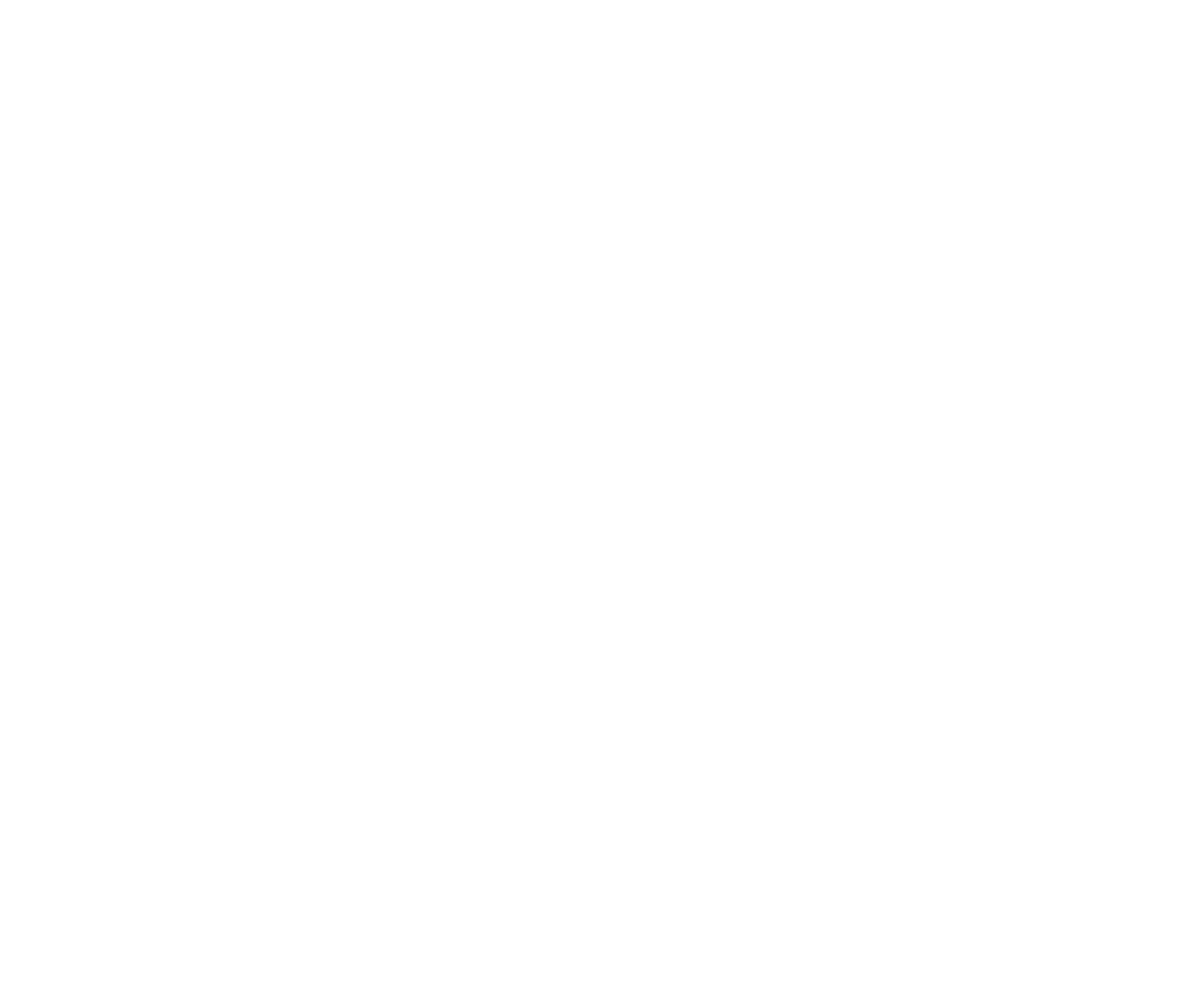